In [16]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error

In [17]:
import numpyro
import numpy as np 

import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

In [18]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 8 Outputs
teff = []
luminosity = []
dnufit = []
FeH = []
G_GAIA = []
massfin = []
numax = []
MeH = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:

    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = list(tracks.keys())
    random.seed(1)
    random.shuffle(track_names)

    # Choose a subset of tracks to process
    num_tracks = 1000  # Set the number of tracks to process
    selected_tracks = track_names[:num_tracks]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        fehini.append(track['FeHini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])

        # Outputs
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        G_GAIA.append(track['G_GAIA'][:])
        massfin.append(track['massfin'][:])
        numax.append(track['numax'][:])
        MeH.append(track['MeH'][:])

# Convert lists to numpy arrays and concatenate them (make one big list)

# Define a small constant to avoid log10(0)
epsilon = 1e-10

# Features requiring log10 transformation
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]

# Transform log10 variables
log10_transformed_inputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_inputs]

# Concatenate all inputs, including raw `fehini` and `yini`
inputs = np.hstack(log10_transformed_inputs + [np.concatenate(fehini).reshape(-1, 1), np.concatenate(yini).reshape(-1, 1)])

# Features requiring log10 transformation (strictly positive outputs)
log10_vars_outputs = [teff, luminosity, dnufit, G_GAIA, massfin, numax]

# Transform log10 variables
log10_transformed_outputs = [np.log10(np.maximum(np.concatenate(var).reshape(-1, 1), epsilon)) for var in log10_vars_outputs]

# Combine transformed log10 outputs with raw FeH and MeH
# FeH and MeH are not transformed, concatenated directly
outputs = np.hstack(log10_transformed_outputs + [np.concatenate(FeH).reshape(-1, 1), np.concatenate(MeH).reshape(-1, 1)])



In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
X_test_tensor = torch.FloatTensor(X_test)
y_train_tensor = torch.FloatTensor(y_train)
y_test_tensor = torch.FloatTensor(y_test)

dataset = TensorDataset(X_train_tensor, y_train_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  


In [65]:
# Define the neural network
class GarstecNet(nn.Module):
    def __init__(self):
        super(GarstecNet, self).__init__()
        self.dense1 = nn.Linear(7, 64)   # Input layer
        self.dense2 = nn.Linear(64, 64)
        self.dense3 = nn.Linear(64, 64)  
        self.dense4 = nn.Linear(64, 64)
        self.dense5 = nn.Linear(64, 64)
        self.dense6 = nn.Linear(64, 8)    # Output layer
        

    def forward(self, x):
        x = torch.relu(self.dense1(x))
        x = torch.relu(self.dense2(x))
        x = torch.relu(self.dense3(x))  
        x = torch.relu(self.dense4(x))
        x = torch.relu(self.dense5(x))
        x = self.dense6(x)
        return x

    
# Load the pre-trained model weights
model = GarstecNet()
model.load_state_dict(torch.load('garstec_model_V3_state.pth'))

# Set the model to evaluation mode
model.eval()
print("Model loaded successfully.")

Model loaded successfully.


C:\Users\Dell\AppData\Local\Temp\ipykernel_34876\3765155684.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('garstec_model_V3_state.pth

In [66]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    predictions = scaler_y.inverse_transform(predictions.numpy())
    y_test_actual = scaler_y.inverse_transform(y_test_tensor.numpy())

    # Calculate evaluation metrics
    r2 = r2_score(y_test_actual, predictions)
    mae = mean_absolute_error(y_test_actual, predictions)

    print(f'R^2 Score: {r2:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')

R^2 Score: 0.9806
Mean Absolute Error: 0.0856


In [37]:
# Select random track from the same 10000 that we trained the NN on
specific_track_name = random.choice(selected_tracks)

# Retrieve all required inputs for the specific track
with h5py.File(garstec_data, 'r') as hdf:
    specific_track = hdf['grid']['tracks'][specific_track_name]

    ages = specific_track['age'][:].reshape(-1, 1)
    massini = specific_track['massini'][:].reshape(-1, 1)
    fehini = specific_track['FeHini'][:].reshape(-1, 1)
    alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
    yini = specific_track['yini'][:].reshape(-1, 1)
    eta = specific_track['eta'][:].reshape(-1, 1)
    alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

    # Combine features into a single array
    all_features = np.hstack((ages, massini, fehini, alphamlt, yini, eta, alphafe))

    # Retrieve actual values for plotting
    teff_specific = specific_track['Teff'][:]
    luminosity_specific = specific_track['LPhot'][:]

# Combine inputs and apply log10 transformations where required
epsilon = 1e-10
log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]

# Combine log-transformed inputs with raw `fehini` and `yini`
all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

# Scale the input features
all_features_scaled = scaler_X.transform(all_features)

# Convert scaled inputs to PyTorch tensor
all_features_tensor = torch.FloatTensor(all_features_scaled)

# Put the model in evaluation mode and make predictions
model.eval()
with torch.no_grad():
    predictions_specific = model(all_features_tensor).numpy()
    predictions_specific = scaler_y.inverse_transform(predictions_specific)
data = 10**predictions_specific
# Extract predicted `Teff` and `Luminosity`
predicted_teff = 10**predictions_specific[:, 0]  # Inverse log10 transformation
predicted_luminosity = 10**predictions_specific[:, 1]
predicted_dnufit = 10**predictions_specific[:, 2]
predicted_FeH = 10**predictions_specific[:, 3]
predicted_G_GAIA = 10**predictions_specific[:, 4]
predicted_massfin = 10**predictions_specific[:, 5]
predicted_numax = 10**predictions_specific[:, 6]
predicted_MeH = 10**predictions_specific[:, 7]

#data = np.hstack([predicted_teff, predicted_luminosity, predicted_dnufit, predicted_FeH, predicted_G_GAIA, predicted_massfin, predicted_numax, predicted_MeH])

In [67]:
n_stars = 30
star_data = []

with h5py.File(garstec_data, 'r') as hdf:
    for _ in range(n_stars):
        # Select a random track
        specific_track_name = np.random.choice(selected_tracks)
        specific_track = hdf['grid']['tracks'][specific_track_name]

        # Retrieve features
        ages = specific_track['age'][:].reshape(-1, 1)
        massini = specific_track['massini'][:].reshape(-1, 1)
        fehini = specific_track['FeHini'][:].reshape(-1, 1)
        alphamlt = specific_track['alphaMLT'][:].reshape(-1, 1)
        yini = specific_track['yini'][:].reshape(-1, 1)
        eta = specific_track['eta'][:].reshape(-1, 1)
        alphafe = specific_track['alphaFe'][:].reshape(-1, 1)

        # Combine features into a single array
        epsilon = 1e-10
        log10_vars_inputs = [ages, massini, alphamlt, eta, alphafe]
        log10_transformed_inputs = [np.log10(np.maximum(var, epsilon)) for var in log10_vars_inputs]
        all_features = np.hstack(log10_transformed_inputs + [fehini, yini])

        # Scale features
        all_features_scaled = scaler_X.transform(all_features)
        all_features_tensor = torch.FloatTensor(all_features_scaled)

        # Make predictions
        model.eval()
        with torch.no_grad():
            predictions_specific = model(all_features_tensor).numpy()
            predictions_specific = scaler_y.inverse_transform(predictions_specific)

        # Extract predicted values
        predicted_teff = 10**predictions_specific[:, 0]
        predicted_luminosity = 10**predictions_specific[:, 1]
        predicted_dnufit = 10**predictions_specific[:, 2]
        predicted_FeH = 10**predictions_specific[:, 3]
        predicted_G_GAIA = 10**predictions_specific[:, 4]
        predicted_massfin = 10**predictions_specific[:, 5]
        predicted_numax = 10**predictions_specific[:, 6]
        predicted_MeH = 10**predictions_specific[:, 7]

        # Store data for each star
        star_data.append({
            'track_name': specific_track_name,
            'features': all_features,  # Original features
            'predicted_values': {
                'Teff': predicted_teff,
                'Luminosity': predicted_luminosity,
                'Dnufit': predicted_dnufit,
                'FeH': predicted_FeH,
                'G_GAIA': predicted_G_GAIA,
                'Massfin': predicted_massfin,
                'Numax': predicted_numax,
                'MeH': predicted_MeH
            }
        })

# The `star_data` list now contains all relevant data for 30 stars, ready for HBM use.


30


In [70]:
def model(teff_=[], luminosity_=[], dnufit_=[], FeH_=[], G_GAIA_=[], massfin_=[], numax_=[], MeH_=[]):
    with numpyro.plate('plate_i', n_stars):
        teff_ = numpyro.sample('teff_', dist.Normal(6000, 1000))
        luminosity_ = numpyro.sample('luminosity_', dist.Normal(80, 50))
        dnufit_ = numpyro.sample('dnufit_', dist.Normal(20, 10))
        FeH_ = numpyro.sample('FeH_', dist.Normal(0, 0.5))
        G_GAIA_ = numpyro.sample('G_GAIA_', dist.Normal(0.8, 0.08))
        massfin_ = numpyro.sample('massfin_', dist.Normal(0.1, 0.1))
        numax_ = numpyro.sample('numax_', dist.Normal(0.023, 0.003))
        MeH_ = numpyro.sample('MeH_', dist.Normal(0.025, 0.2))

    if len(teff_) > 1 and len(luminosity_) > 1 and len(dnufit_) > 1 and len(FeH_) > 1 and len(G_GAIA_) > 1 and len(massfin_) > 1 and len(numax_) > 1 and len(MeH_) > 1:
        with numpyro.plate('data', n_stars):
            numpyro.sample('obs_teff_', dist.Normal(teff_, 5.0), obs=teff_)
            numpyro.sample('obs_luminosity_', dist.Normal(luminosity_, 5.0), obs=luminosity_)
            numpyro.sample('obs_dnufit_', dist.Normal(dnufit_, 5.0), obs=dnufit_)
            numpyro.sample('obs_FeH_', dist.Normal(FeH_, 5.0), obs=FeH_)
            numpyro.sample('obs_G_GAIA_', dist.Normal(G_GAIA_, 5.0), obs=G_GAIA_)
            numpyro.sample('obs_massfin_', dist.Normal(massfin_, 5.0), obs=massfin_)
            numpyro.sample('obs_numax_', dist.Normal(numax_, 5.0), obs=numax_)
            numpyro.sample('obs_MeH_', dist.Normal(MeH_, 5.0), obs=MeH_)



In [71]:
from jax import random

nuts_kernel = NUTS(model)

hbm_mcmc = MCMC(nuts_kernel, num_samples=4000, num_warmup=4000)
rng_key = random.PRNGKey(0)
hbm_mcmc.run(rng_key, data)

posterior_samples = hbm_mcmc.get_samples()

sample: 100%|██████████| 8000/8000 [00:11<00:00, 690.47it/s, 15 steps of size 3.56e-01. acc. prob=0.86] 


In [72]:
hbm_mcmc.print_summary()


                     mean       std    median      5.0%     95.0%     n_eff     r_hat
        FeH_[0]     -0.00      0.51     -0.01     -0.80      0.86  11254.03      1.00
        FeH_[1]     -0.00      0.49     -0.01     -0.85      0.76  12843.52      1.00
        FeH_[2]     -0.01      0.47     -0.01     -0.80      0.75  10275.26      1.00
        FeH_[3]      0.00      0.51     -0.00     -0.82      0.84  13455.40      1.00
        FeH_[4]     -0.00      0.50      0.00     -0.81      0.84  10694.38      1.00
        FeH_[5]      0.00      0.50     -0.00     -0.82      0.82  10434.94      1.00
        FeH_[6]      0.00      0.50     -0.00     -0.85      0.80  12231.33      1.00
        FeH_[7]      0.00      0.48      0.00     -0.83      0.74  11809.18      1.00
        FeH_[8]      0.00      0.51      0.00     -0.79      0.84  12886.20      1.00
        FeH_[9]     -0.00      0.50     -0.01     -0.80      0.83  11343.96      1.00
       FeH_[10]      0.01      0.51      0.01     -0.

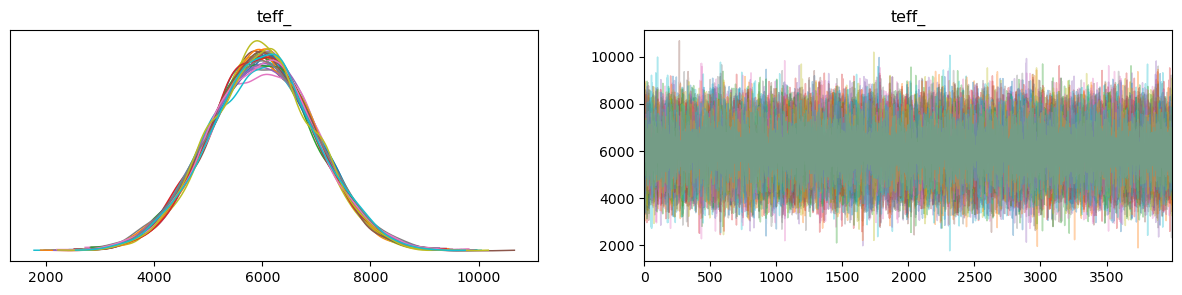

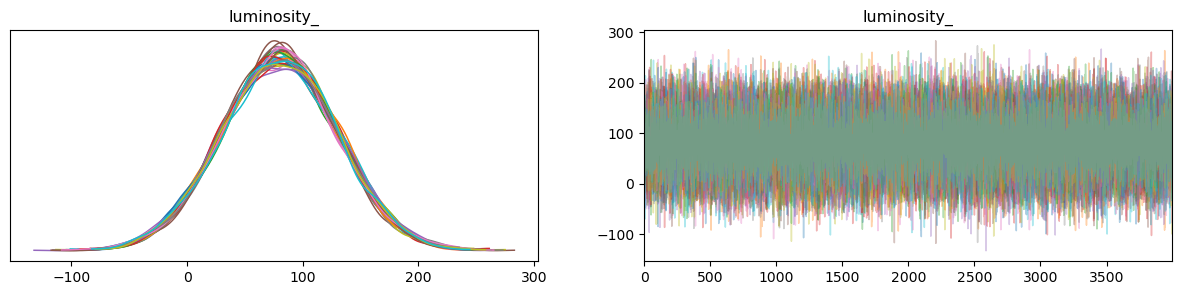

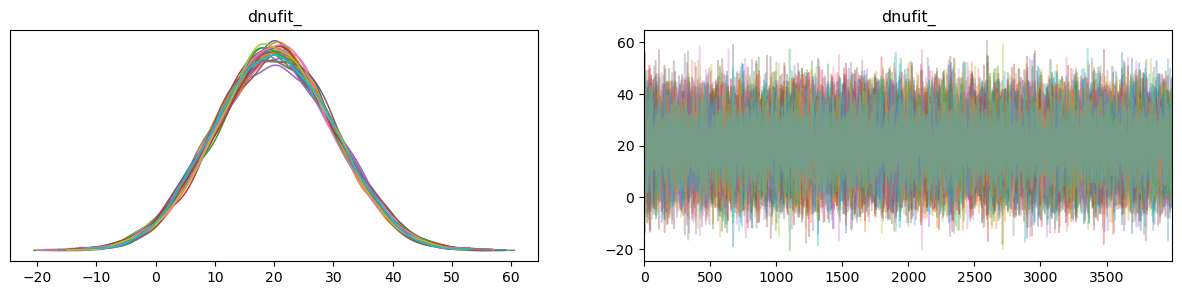

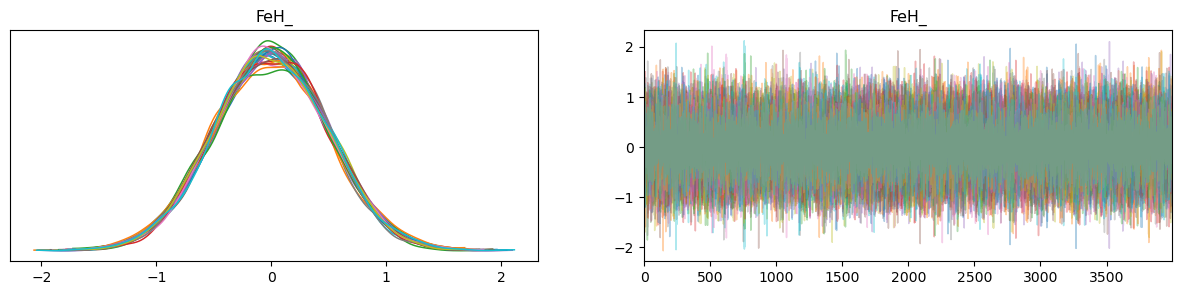

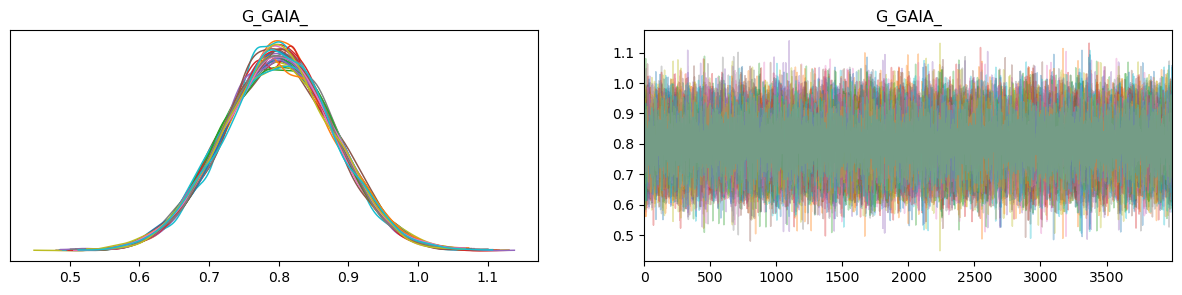

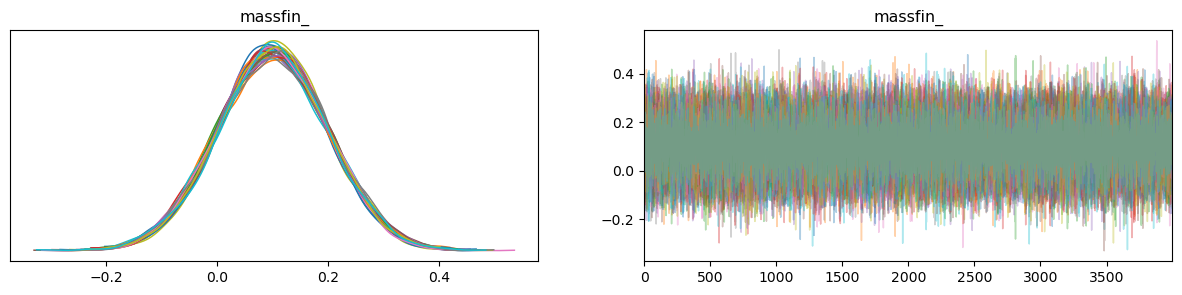

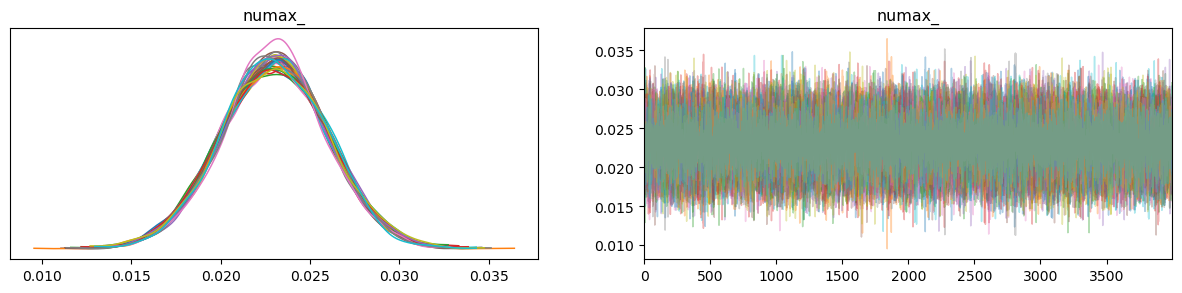

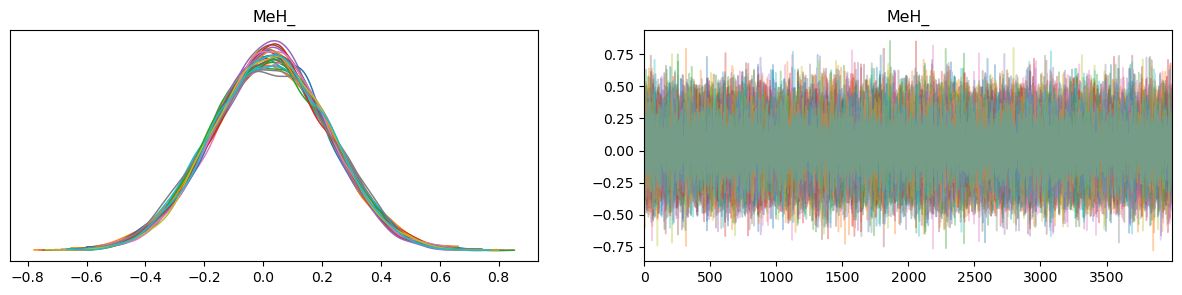

In [75]:
import arviz as az

hbm_data = az.from_numpyro(hbm_mcmc)
az.plot_trace(hbm_data, var_names=['teff_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['luminosity_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['dnufit_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['FeH_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['G_GAIA_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['massfin_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['numax_'], compact=True, figsize=(15, 3));
az.plot_trace(hbm_data, var_names=['MeH_'], compact=True, figsize=(15, 3));